# **Convergence of EM Algorithm for Gaussian Mixture Models**

The speed of convergence of the Expectation Maximization (EM) algorithm for Gaussian mixture model fitting is known to be dependent on the amount of overlap among the mixture components. In this project, we study the impact of mixing coefficients on the convergence of EM. We show that when the mixture components exhibit some overlap, the convergence of EM becomes slower as the dynamic range among the mixing coefficients increases. We propose a deterministic anti-annealing algorithm (DAEM), that significantly improves the speed of convergence of EM for such mixtures with unbalanced mixing coefficients. However when the dataset has a relatively larger covariance (like that of the Iris dataset) , DAEM might get slow. We increase the speed by introducing a modification in DAEM algorithm without altering its convergence criteria.

The difference in Standard EM Algorithm and DAEM lies in the updation parameter (hⱼ(t)) in Expectation step.The Maximization step remains the same for all algorithms.

EM Algorithm: hⱼ(t) = (αⱼP(xₜ|µⱼ,Σⱼ)) / ⅀(αᵢP(xₜ|µⱼ,Σⱼ))

DAEM Algorithm: hⱼ(t) = (αⱼP(xₜ|µⱼ,Σⱼ))^(β) / ⅀(αᵢP(xₜ|µⱼ,Σⱼ))^(β) where β is the scheduling parameter

Modified DAEM Algorithm: hⱼ(t) = (αⱼP(xₜ|µⱼ,Σⱼ))^(β+αⱼ) / ⅀(αᵢP(xₜ|µⱼ,Σⱼ))^(β+αⱼ)


As the rate of convergence of the above-discussed algorithms increase, the number of computations as well as time complexity also increases. So for general purposes, the EM algorithm is preferred.



# **Dataset 1 (Multivariate Gaussian distribution sample)**

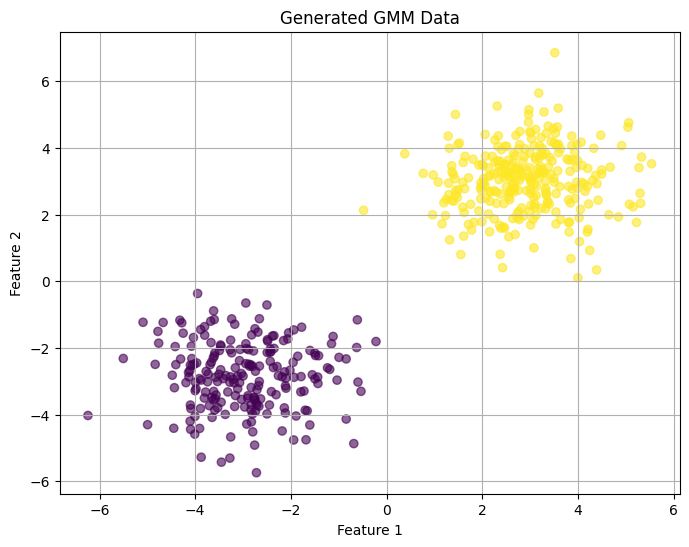

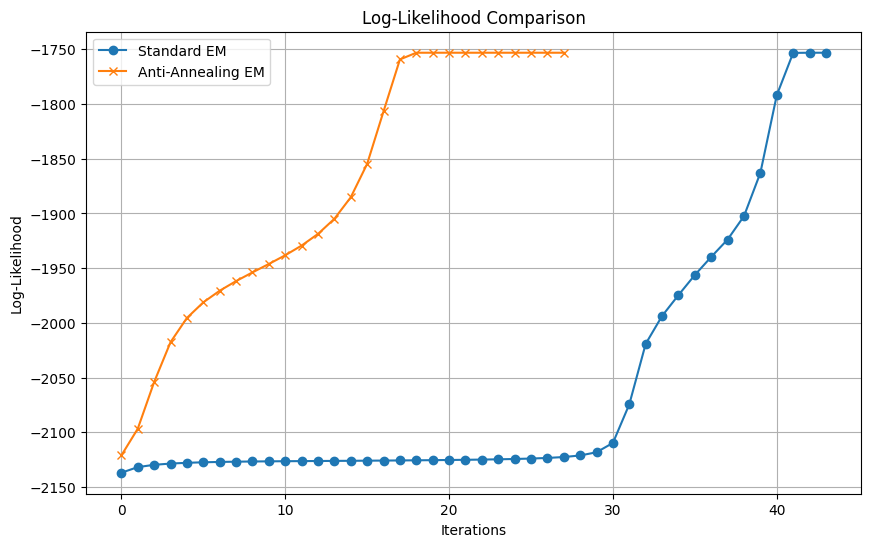

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Generate GMM Data
def generate_gmm_data(weights, means, covariances, n_samples):

    n_components = len(weights)
    data = []
    labels = []

    for i in range(n_samples):
        # Choose a component based on weights
        component = np.random.choice(range(n_components), p=weights)
        # Sample from the chosen Gaussian
        sample = np.random.multivariate_normal(means[component], covariances[component])
        data.append(sample)
        labels.append(component)

    return np.array(data), np.array(labels)

# E-step of EM Algorithm
def e_step(data, weights, means, covariances, beta=1.0):

    n_samples, n_components = data.shape[0], len(weights)
    responsibilities = np.zeros((n_samples, n_components))

    for k in range(n_components):
        prob = multivariate_normal.pdf(data, mean=means[k], cov=covariances[k])
        responsibilities[:, k] = (weights[k] * prob) ** beta

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# M-step of EM Algorithm
def m_step(data, responsibilities):

    n_samples, n_features = data.shape
    n_components = responsibilities.shape[1]

    weights = responsibilities.sum(axis=0) / n_samples
    means = (responsibilities.T @ data) / responsibilities.sum(axis=0)[:, None]
    covariances = []

    for k in range(n_components):
        diff = data - means[k]
        cov = (responsibilities[:, k][:, None] * diff).T @ diff / responsibilities[:, k].sum()
        covariances.append(cov)

    return weights, means, np.array(covariances)

# Log-likelihood computation
def log_likelihood(data, weights, means, covariances):

    log_likelihood = 0
    for i in range(data.shape[0]):
        prob = 0
        for k in range(len(weights)):
            prob += weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
        log_likelihood += np.log(prob)
    return log_likelihood

# Standard EM Algorithm
def standard_em(data, n_components, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features) * 10 - 5
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for iteration in range(max_iter):
        responsibilities = e_step(data, weights, means, covariances)
        weights, means, covariances = m_step(data, responsibilities)
        ll = log_likelihood(data, weights, means, covariances)
        log_likelihoods.append(ll)

        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return weights, means, covariances, log_likelihoods

# Anti-Annealing EM Algorithm
def anti_annealing_em(data, n_components, beta_schedule, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features) * 10 - 5
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for beta in beta_schedule:
        for iteration in range(max_iter):
            responsibilities = e_step(data, weights, means, covariances, beta)
            weights, means, covariances = m_step(data, responsibilities)
            ll = log_likelihood(data, weights, means, covariances)
            log_likelihoods.append(ll)

            if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                break

    return weights, means, covariances, log_likelihoods

# Main Code
np.random.seed(42)
weights_true = [0.4, 0.6]
means_true = [np.array([-3, -3]), np.array([3, 3])]
covariances_true = [np.eye(2), np.eye(2)]
data, labels = generate_gmm_data(weights_true, means_true, covariances_true, n_samples=500)

# Scatter plot of the data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title("Generated GMM Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

print("\n\n\n\n\n")

# Run Standard EM
i,i,i, log_likelihoods_em = standard_em(data, n_components=2)

# Run Anti-Annealing EM
beta_schedule = [0.5, 0.8, 1.0, 1.2, 1.5, 1.2, 1.0]
i, i, i, log_likelihoods_aa_em = anti_annealing_em(data, n_components=2, beta_schedule=beta_schedule)

# Plot the log-likelihoods
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods_em, label="Standard EM", marker='o')
plt.plot(log_likelihoods_aa_em, label="Anti-Annealing EM", marker='x')
plt.title("Log-Likelihood Comparison")
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid()
plt.show()
print("\n\n\n\n\n")




# Therefore, we can say that the Deterministic Anti-Annealing EM (DAEM) algorithm gives faster convergence than the standard EM algorithm for multivariate Gaussian distribution. Next we will check the convergence rate for a noisy datasets like Wine aand Iris datasets and compare them.

---


# **Dataset 2 (Wine Dataset)**

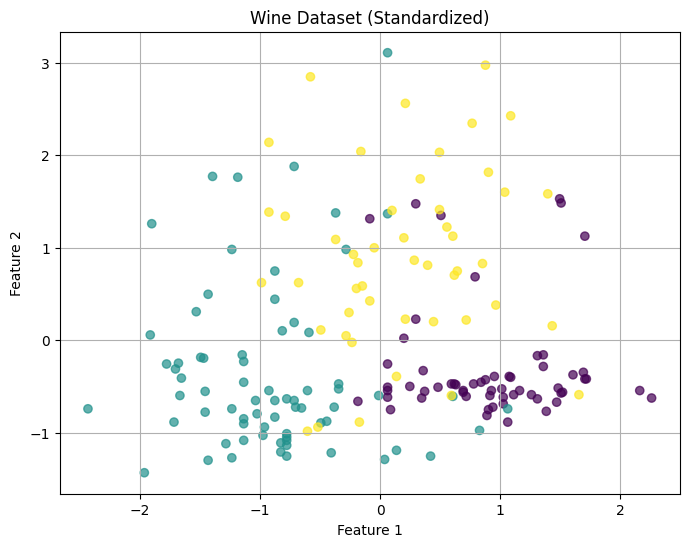

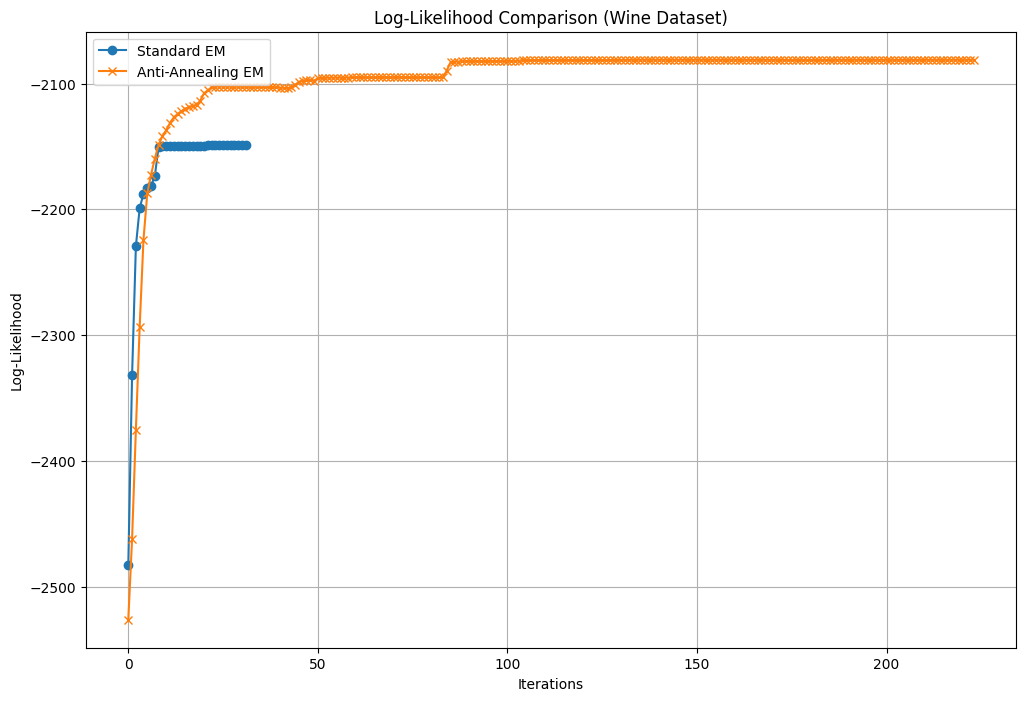

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# E-step of EM Algorithm
def e_step(data, weights, means, covariances, beta=1.0):

    n_samples, n_components = data.shape[0], len(weights)
    responsibilities = np.zeros((n_samples, n_components))

    for k in range(n_components):
        prob = multivariate_normal.pdf(data, mean=means[k], cov=covariances[k])
        responsibilities[:, k] = (weights[k] * prob) ** beta

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# M-step of EM Algorithm
def m_step(data, responsibilities):

    n_samples, n_features = data.shape
    n_components = responsibilities.shape[1]

    weights = responsibilities.sum(axis=0) / n_samples
    means = (responsibilities.T @ data) / responsibilities.sum(axis=0)[:, None]
    covariances = []

    for k in range(n_components):
        diff = data - means[k]
        cov = (responsibilities[:, k][:, None] * diff).T @ diff / responsibilities[:, k].sum()
        covariances.append(cov)

    return weights, means, np.array(covariances)

# Log-likelihood computation
def log_likelihood(data, weights, means, covariances):

    log_likelihood = 0
    for i in range(data.shape[0]):
        prob = 0
        for k in range(len(weights)):
            prob += weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
        log_likelihood += np.log(prob)
    return log_likelihood

# Standard EM Algorithm
def standard_em(data, n_components, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for iteration in range(max_iter):
        responsibilities = e_step(data, weights, means, covariances)
        weights, means, covariances = m_step(data, responsibilities)
        ll = log_likelihood(data, weights, means, covariances)
        log_likelihoods.append(ll)

        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return weights, means, covariances, log_likelihoods

# Anti-Annealing EM Algorithm
def anti_annealing_em(data, n_components, beta_schedule, max_iter=50, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for beta in beta_schedule:
        for iteration in range(max_iter):
            responsibilities = e_step(data, weights, means, covariances, beta)
            weights, means, covariances = m_step(data, responsibilities)
            ll = log_likelihood(data, weights, means, covariances)
            log_likelihoods.append(ll)

            if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                break

    return weights, means, covariances, log_likelihoods

# Set Random Seed
np.random.seed(42)

# Load and preprocess the Wine dataset
wine = load_wine()
data = wine.data  # Extract features
target = wine.target  # Extract true labels
scaler = StandardScaler()  # Standardize the data
data = scaler.fit_transform(data)

# Scatter plot of the first two features
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=target, cmap='viridis', alpha=0.7)
plt.title("Wine Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()
print("\n\n\n\n\n")

# Run Standard EM
n_components = 3  # Number of Gaussian components
_, _, _, log_likelihoods_em = standard_em(data, n_components=n_components)

# Run Anti-Annealing EM
beta_schedule = [0.5, 0.8, 1.0, 1.2, 1.5, 1.2, 1.0]
_, _, _, log_likelihoods_aa_em = anti_annealing_em(data, n_components=n_components, beta_schedule=beta_schedule)

# Plot the log-likelihoods
plt.figure(figsize=(12, 8))
plt.plot(log_likelihoods_em, label="Standard EM", marker='o')
plt.plot(log_likelihoods_aa_em, label="Anti-Annealing EM", marker='x')
plt.title("Log-Likelihood Comparison (Wine Dataset)")
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid()
plt.show()


# We can see that Standard EM gets stuck at a local maxima whereas the DAEM algorithm is able to overcome the local maxima and converge to global maxima (or higher local maxima).

---



# **Dataset 3 (Iris Dataset)**

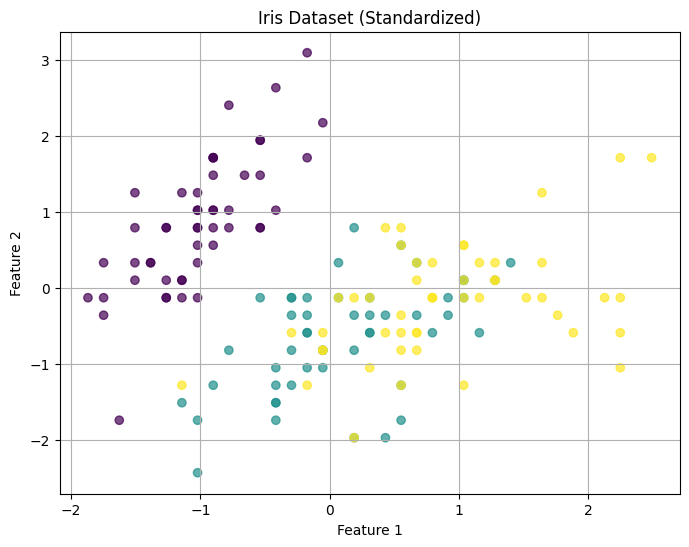

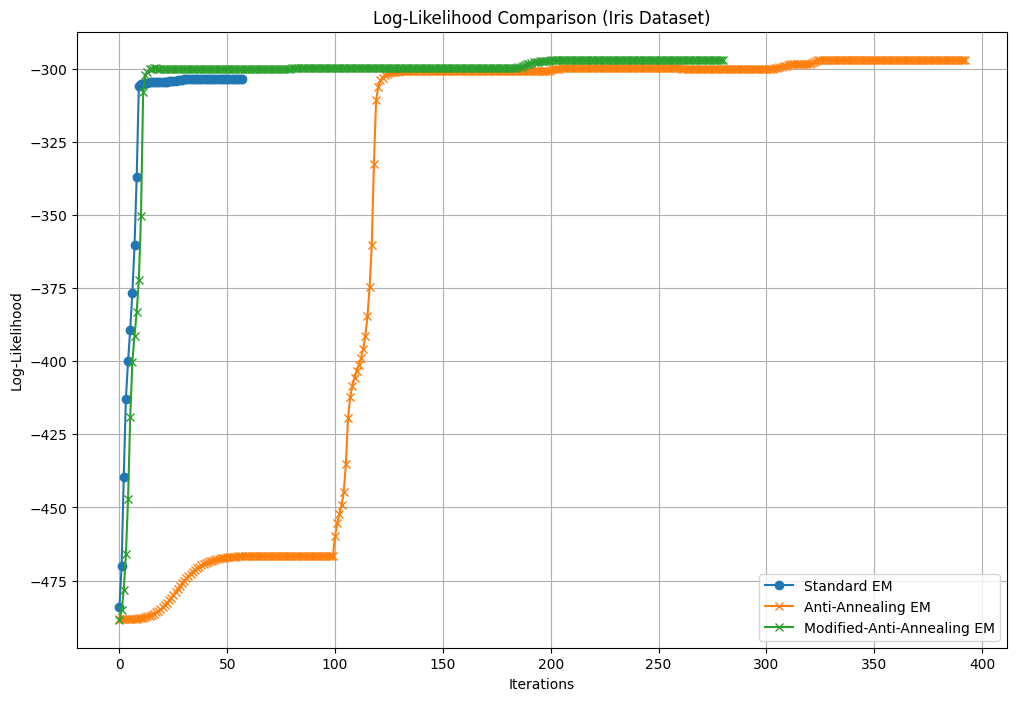

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# E-step of EM Algorithm
def e_step(data, weights, means, covariances, beta=1.0, indicator=1):

    n_samples, n_components = data.shape[0], len(weights)
    responsibilities = np.zeros((n_samples, n_components))

    for k in range(n_components):
        prob = multivariate_normal.pdf(data, mean=means[k], cov=covariances[k])
        if indicator == 1:
            responsibilities[:, k] = (weights[k] * prob) ** beta
        else:
            responsibilities[:, k] = (weights[k] *( prob)) **(beta + weights[k])

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# M-step of EM Algorithm
def m_step(data, responsibilities):

    n_samples, n_features = data.shape
    n_components = responsibilities.shape[1]

    weights = responsibilities.sum(axis=0) / n_samples
    means = (responsibilities.T @ data) / responsibilities.sum(axis=0)[:, None]
    covariances = []

    for k in range(n_components):
        diff = data - means[k]
        cov = (responsibilities[:, k][:, None] * diff).T @ diff / responsibilities[:, k].sum()
        covariances.append(cov)

    return weights, means, np.array(covariances)

# Log-likelihood computation
def log_likelihood(data, weights, means, covariances):

    log_likelihood = 0
    for i in range(data.shape[0]):
        prob = 0
        for k in range(len(weights)):
            prob += weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
        log_likelihood += np.log(prob)
    return log_likelihood

# Standard EM Algorithm
def standard_em(data, n_components, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for iteration in range(max_iter):
        responsibilities = e_step(data, weights, means, covariances)
        weights, means, covariances = m_step(data, responsibilities)
        ll = log_likelihood(data, weights, means, covariances)
        log_likelihoods.append(ll)

        if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return weights, means, covariances, log_likelihoods

# Deterministic Anti-Annealing EM Algorithm
def anti_annealing_em(data, n_components, beta_schedule, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for beta in beta_schedule:
        for iteration in range(max_iter):
            responsibilities = e_step(data, weights, means, covariances, beta)
            weights, means, covariances = m_step(data, responsibilities)
            ll = log_likelihood(data, weights, means, covariances)
            log_likelihoods.append(ll)

            if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                break

    return weights, means, covariances, log_likelihoods

# Modified Anti-Annealing EM Algorithm
def modified_anti_annealing_em(data, n_components, beta_schedule, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    weights = np.ones(n_components) / n_components
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    log_likelihoods = []

    for beta in beta_schedule:
        for iteration in range(max_iter):
            responsibilities = e_step(data, weights, means, covariances, beta , indicator = 2)
            weights, means, covariances = m_step(data, responsibilities)
            ll = log_likelihood(data, weights, means, covariances)
            log_likelihoods.append(ll)

            if len(log_likelihoods) > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                break

    return weights, means, covariances, log_likelihoods

# Set Random Seed
np.random.seed(25)

# Load and preprocess the Iris dataset
iris = load_iris()
data = iris.data  # Extract features
target = iris.target  # Extract true labels
scaler = StandardScaler()  # Standardize the data
data = scaler.fit_transform(data)

# Scatter plot of the first two features
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=target, cmap='viridis', alpha=0.7)
plt.title("Iris Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()
print("\n\n\n\n\n")

# Run Standard EM
n_components = 3  # Number of Gaussian components
_, _, _, log_likelihoods_em = standard_em(data, n_components=n_components)

# Run Anti-Annealing EM
beta_schedule = [0.5, 0.8, 1.0, 1.2, 1.5, 1.2, 1.0]
_, _, _, log_likelihoods_aa_em = anti_annealing_em(data, n_components=n_components, beta_schedule=beta_schedule)
_, _, _, log_likelihoods_maa_em = modified_anti_annealing_em(data, n_components=n_components, beta_schedule=beta_schedule)

# Plot the log-likelihoods
plt.figure(figsize=(12, 8))
plt.plot(log_likelihoods_em, label="Standard EM", marker='o')
plt.plot(log_likelihoods_aa_em, label="Anti-Annealing EM", marker='x')
plt.plot(log_likelihoods_maa_em, label="Modified-Anti-Annealing EM", marker='x')
plt.title("Log-Likelihood Comparison (Iris Dataset)")
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.grid()
plt.show()

# For the iris dataset we see again that the standard EM algorithm gets stuck at a local maxima, which gets overcome by the DAEM algorithm. But since the convergence rate is slower, we implemented a modification of DAEM in which the scheduling parameter (β) is replaced with (β + αⱼ), where αⱼ is the weight of the j-th Gaussian cluster.